## Importing the required libraries

In [6]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [7]:
from keras import regularizers

In [8]:
import os

In [9]:
mylist= os.listdir('RawData/')

In [10]:
type(mylist)

list

In [11]:
print(mylist[1800])

KL_a01.wav


In [12]:
print(mylist[400][6:-16])

03


## Plotting the audio file's waveform and its spectrogram

In [13]:
data, sampling_rate = librosa.load('RawData/03-01-01-01-01-01-01.wav')

In [14]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

UsageError: Line magic function `%` not found.


C:\Users\Vaibh\AppData\Local\Temp\ipykernel_17776\3692620404.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr,x = scipy.io.wavfile.read('RawData/03-01-01-01-01-01-02.wav')
C:\Users\Vaibh\AppData\Local\Temp\ipykernel_17776\3692620404.py:26: RuntimeWarning: divide by zero encountered in log
  X[i,:] = np.log(np.abs(z[:nfft//2]))


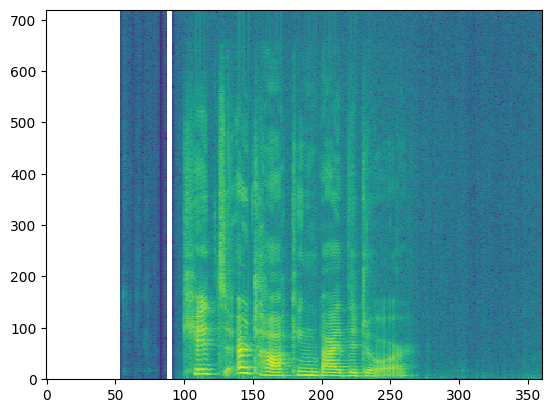

In [15]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('RawData/03-01-01-01-01-01-02.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Setting the labels

In [16]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')

In [17]:
import pandas as pd
labels = pd.DataFrame(feeling_list)

In [18]:
labels[:10]

,0
0,male_calm
1,female_calm
2,male_calm
3,female_calm
4,male_calm
5,female_calm
6,male_calm
7,female_calm
8,male_calm
9,female_calm


## Getting the features of audio files using librosa

In [19]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('RawData/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [20]:
df[:5]

,feature
0,"[-70.26808, -70.26808, -70.26808, -70.26808, -..."
1,"[-65.707375, -65.707375, -63.11476, -61.5191, ..."
2,"[-65.48282, -65.48282, -65.48282, -65.48282, -..."
3,"[-64.52863, -64.52863, -64.52863, -64.52863, -..."
4,"[-63.64624, -59.995125, -61.87015, -67.49628, ..."


In [21]:
df3 = pd.DataFrame(df['feature'].values.tolist())

df3[:5]

In [22]:
newdf = pd.concat([df3,labels], axis=1)

In [23]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [24]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-57.447964,-58.897030,-58.751503,-57.406185,-60.078960,-63.427284,-62.639057,-61.242519,-61.356304,male_calm
1,-65.707375,-65.707375,-63.114761,-61.519100,-61.097507,-63.424744,-63.720127,-56.854958,-55.169304,-54.640343,...,-39.792599,-40.614021,-41.209984,-41.439613,-43.994675,-49.399967,-50.591972,-49.112217,-48.155739,female_calm
2,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,...,-31.348972,-34.310616,-35.803104,-35.938644,-37.633038,-40.119915,-41.663399,-41.552986,-41.974155,male_calm
3,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-65.928391,...,-48.674789,-48.596626,-47.603218,-43.049660,-42.660038,-43.189026,-44.001690,-43.328537,-42.985413,female_calm
4,-63.646240,-59.995125,-61.870152,-67.496277,-71.072220,-65.680321,-63.394951,-65.503853,-61.858971,-60.007893,...,-39.072914,-41.896793,-40.866905,-38.293262,-36.375126,-37.914909,-40.027390,-43.315861,-44.848812,male_calm


In [25]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
104,-78.189468,-78.189468,-78.189468,-78.189468,-78.189468,-73.816086,-72.412430,-73.099991,-67.493103,-68.776360,...,-58.762104,-57.633610,-56.139297,-56.323708,-56.565144,-55.806450,-56.874107,-54.265041,-54.132404,male_calm
67,-78.175575,-78.175575,-78.175575,-78.175575,-78.175575,-78.175575,-78.175575,-78.175575,-78.175575,-78.175575,...,-71.519547,-72.790489,-74.491753,-70.992569,-71.379715,-70.568588,-67.883209,-67.966072,-71.924637,female_calm
1040,-7.710930,-8.262999,-10.783083,-9.869562,-10.170098,-10.380073,-11.160921,-11.283401,-12.254766,-13.035592,...,-9.951582,-9.711096,-9.834348,-9.618107,-8.442469,-8.556031,-8.778090,-6.693377,-2.237410,NaN
34,-66.146324,-56.576275,-54.119465,-55.746223,-55.997902,-55.565292,-55.623657,-56.577393,-55.227451,-55.989052,...,-48.737469,-48.932983,-49.597916,-51.275921,-55.083782,-57.042488,-56.337814,-56.371140,-57.252113,male_calm
1338,-31.203026,-30.356993,-30.623898,-28.531658,-27.617348,-28.205536,-28.279921,-29.310301,-30.748741,-28.886883,...,-26.327038,-27.590797,-29.250181,-30.572010,-31.713408,-33.979652,-36.425125,-37.389530,-33.268051,NaN
1158,-8.781925,-13.116877,-26.692326,-26.290775,-26.120573,-25.185495,-26.745653,-26.716648,-26.666586,-29.313015,...,-4.931312,-5.652874,-6.559098,-6.846932,-7.464545,-8.307590,-9.427171,-10.954204,-6.839266,NaN
590,-53.564453,-51.601479,-51.791424,-50.351364,-49.195034,-50.755043,-49.357727,-50.551376,-49.749855,-49.611729,...,-46.751301,-45.180019,-45.935581,-44.928589,-43.880196,-43.154545,-43.734516,-44.456322,-45.407234,male_angry
676,-43.103676,-43.103676,-43.103676,-43.103676,-43.103676,-43.103676,-42.741909,-42.918076,-43.103676,-43.103676,...,-43.078342,-43.103676,-43.103676,-43.103676,-43.103676,-42.908737,-43.103676,-43.103676,-43.103676,male_angry
1245,-6.906571,-10.806870,-20.985638,-17.276081,-15.831626,-17.807178,-19.676676,-20.520412,-19.503632,-12.970485,...,-5.828334,-3.369664,-1.005752,-1.280487,-4.248908,-8.564584,-9.106207,-4.759642,2.194722,NaN
909,-50.638638,-50.638638,-50.638638,-50.679428,-50.035275,-48.822079,-48.889629,-44.468399,-40.813301,-41.148109,...,-50.638638,-50.638638,-50.638638,-50.638638,-50.638638,-50.638638,-50.638638,-50.638638,-50.638638,female_fearful


In [26]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [27]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]
print(type(train))
print(type(test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [28]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
955,-32.224686,-28.745176,-24.918324,-24.495335,-24.847006,-25.156597,-24.030565,-25.512342,-27.974283,-31.118340,...,-36.447788,-36.467873,-36.526020,-36.526020,-36.526020,-36.526020,-36.526020,-36.526020,-36.526020,female_fearful
727,-48.894554,-48.275658,-45.958027,-44.900471,-46.196793,-44.841270,-44.851910,-45.880287,-46.070049,-47.612591,...,-45.364460,-45.689724,-47.802433,-48.201256,-48.303593,-48.791073,-47.894573,-48.794132,-48.894554,female_angry
578,-65.754807,-65.097015,-62.692932,-61.769325,-62.096008,-62.928463,-65.444389,-64.496429,-61.917049,-59.725552,...,-31.036987,-31.215090,-30.572193,-30.169285,-30.590586,-33.742764,-36.739731,-38.406097,-37.462227,male_angry
1242,-2.215343,-4.855505,-7.076339,-8.511169,-10.024297,-14.448679,-18.549864,-18.590797,-20.521416,-23.395082,...,-24.255131,-23.579103,-22.712215,-23.136110,-22.836775,-24.121744,-23.641294,-20.833965,-15.155352,0
1115,-6.955714,-10.824881,-21.576975,-21.383625,-22.160576,-23.253313,-23.793720,-22.784742,-23.054525,-22.865305,...,-26.392271,-27.870152,-27.895943,-27.137480,-26.777651,-25.588314,-25.383944,-16.949408,-8.940098,0
1368,-18.576942,-22.158924,-28.685890,-28.028980,-30.085142,-31.538408,-30.330540,-32.387249,-31.970201,-30.251207,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
715,-40.888103,-40.696514,-40.556133,-40.733177,-40.456642,-40.096287,-40.340477,-40.320091,-40.263981,-40.394524,...,-30.757490,-31.946041,-31.467747,-32.113770,-32.847618,-32.053196,-30.832691,-22.030485,-16.540558,female_angry
1217,-9.075974,-12.890634,-13.369646,-11.934773,-12.165018,-13.162649,-12.355381,-12.649297,-12.727711,-14.601623,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
26,-65.303253,-65.303253,-65.303253,-65.303253,-65.303253,-65.303253,-65.303253,-65.303253,-65.303253,-65.303253,...,-37.281231,-38.535637,-40.021580,-40.174664,-41.068069,-40.677696,-41.743950,-42.340263,-44.397686,male_calm
1267,-8.984964,-12.957250,-14.342284,-5.504913,-3.335017,-4.035428,-4.916646,-3.913570,-4.277874,-5.083914,...,-8.032699,-11.102783,-11.426847,-12.732146,-10.281778,-10.181544,-12.484471,-10.725393,-8.244575,0


In [29]:
trainfeatures = train.iloc[:, :-1]

In [30]:
trainlabel = train.iloc[:, -1:]
print(type(trainlabel))

<class 'pandas.core.frame.DataFrame'>


In [31]:
testfeatures = test.iloc[:, :-1]

In [32]:
testlabel = test.iloc[:, -1:]
print(type(testlabel))

<class 'pandas.core.frame.DataFrame'>


In [85]:

from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel, dtype=str)  # Convert all labels to string
X_test = np.array(testfeatures)
y_test = np.array(testlabel, dtype=str)  # Convert all labels to string

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))  # Use transform instead of fit_transform on test data



In [86]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [87]:
X_train.shape

(1160, 216)

## Changing dimension for CNN model

In [88]:

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [92]:
from tensorflow.keras.optimizers import RMSprop

model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = RMSprop(learning_rate=0.00001, decay=1e-6)

In [93]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 216, 256)          1536      
                                                                 
 activation_25 (Activation)  (None, 216, 256)          0         
                                                                 
 conv1d_21 (Conv1D)          (None, 216, 128)          163968    
                                                                 
 activation_26 (Activation)  (None, 216, 128)          0         
                                                                 
 dropout_5 (Dropout)         (None, 216, 128)          0         
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 27, 128)          0         
 1D)                                                             
                                                      

In [94]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

### Removed the whole training part for avoiding unnecessary long epochs list

In [106]:
from tensorflow.keras.utils import to_categorical
# print(x_testcnn)

# Convert labels to one-hot encoded arrays
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)


cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700, validation_data=(x_testcnn, y_test))

MemoryError: Unable to allocate 4.75 GiB for an array with shape (1160, 11, 10, 10, 10, 10, 10) and data type int32

In [96]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'cnnhistory' is not defined

## Saving the model

In [112]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\mites\Documents\Cognitive\Final Exam\saved_models\Emotion_Voice_Detection_Model.h5 


In [133]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [137]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 72.73%


## Predicting emotions on the test data

In [138]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

319/319 [==============================] - 0s     


In [139]:
preds

array([[  3.49815641e-12,   1.18043589e-10,   1.13181663e-19, ...,
          1.80016723e-05,   7.36836637e-06,   1.14132257e-04],
       [  3.87504338e-16,   5.73074694e-23,   1.31673211e-14, ...,
          1.75147681e-04,   1.85760673e-05,   9.99805748e-01],
       [  8.39285008e-07,   3.43896300e-11,   5.38965035e-03, ...,
          9.93317604e-01,   1.99900052e-04,   1.05243188e-03],
       ..., 
       [  3.49616457e-04,   1.94651744e-04,   6.65218568e-06, ...,
          1.67340226e-02,   6.44345134e-02,   9.10043001e-01],
       [  4.23396705e-06,   1.59581254e-11,   6.03030126e-12, ...,
          6.36715861e-03,   9.64888096e-01,   2.34207995e-02],
       [  3.69524572e-31,   0.00000000e+00,   0.00000000e+00, ...,
          5.24333927e-07,   9.99998808e-01,   6.36476927e-10]], dtype=float32)

In [115]:
preds1=preds.argmax(axis=1)

In [116]:
preds1

array([6, 9, 7, 1, 7, 8, 1, 2, 5, 8, 7, 1, 9, 9, 4, 0, 5, 0, 5, 8, 4, 1, 5,
       9, 7, 5, 7, 1, 7, 5, 8, 1, 8, 9, 2, 2, 1, 8, 6, 0, 5, 9, 1, 0, 7, 5,
       5, 7, 7, 0, 0, 7, 0, 0, 6, 5, 3, 7, 5, 8, 5, 4, 8, 8, 9, 7, 2, 8, 6,
       1, 5, 6, 8, 6, 5, 3, 4, 8, 8, 9, 9, 0, 8, 9, 4, 5, 0, 0, 5, 5, 7, 9,
       4, 7, 8, 6, 9, 5, 6, 8, 1, 7, 0, 8, 8, 7, 3, 2, 7, 8, 7, 9, 7, 9, 5,
       7, 8, 6, 0, 1, 6, 9, 1, 5, 8, 7, 1, 8, 6, 9, 3, 7, 7, 4, 6, 5, 8, 8,
       1, 0, 5, 0, 7, 6, 5, 7, 4, 9, 2, 5, 4, 7, 5, 6, 8, 5, 5, 4, 8, 8, 2,
       7, 5, 7, 6, 9, 8, 9, 9, 0, 2, 5, 7, 8, 3, 0, 4, 6, 6, 9, 9, 9, 3, 8,
       1, 7, 2, 5, 8, 1, 8, 4, 4, 8, 5, 2, 9, 9, 5, 6, 0, 5, 9, 0, 8, 7, 4,
       6, 6, 3, 9, 5, 9, 6, 1, 7, 5, 7, 8, 4, 9, 2, 5, 6, 6, 4, 2, 1, 8, 2,
       7, 5, 7, 3, 5, 6, 8, 7, 1, 6, 0, 0, 4, 7, 4, 4, 4, 4, 4, 0, 8, 1, 6,
       7, 4, 8, 7, 8, 2, 9, 6, 2, 7, 8, 3, 9, 9, 7, 2, 5, 7, 2, 9, 5, 5, 7,
       8, 5, 6, 8, 1, 2, 5, 9, 4, 5, 5, 6, 7, 8, 7, 0, 9, 5, 9, 5, 9, 7, 8,
       1, 2,

In [117]:
abc = preds1.astype(int).flatten()

In [118]:
predictions = (lb.inverse_transform((abc)))

In [119]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_calm
1,male_sad
2,male_fearful
3,female_calm
4,male_fearful
5,male_happy
6,female_calm
7,female_fearful
8,male_angry
9,male_happy


In [120]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [121]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_calm
1,male_sad
2,male_fearful
3,female_fearful
4,male_fearful
5,male_happy
6,female_calm
7,female_angry
8,male_angry
9,male_happy


In [122]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [128]:
finaldf[170:180]

,actualvalues,predictedvalues
170,female_fearful,female_fearful
171,male_angry,male_angry
172,male_fearful,male_fearful
173,male_happy,male_happy
174,female_happy,female_happy
175,female_angry,female_angry
176,female_angry,female_sad
177,male_sad,male_calm
178,male_angry,male_calm
179,male_sad,male_sad


In [129]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,21
female_calm,20
female_fearful,19
female_happy,17
female_sad,20
male_angry,55
male_calm,25
male_fearful,55
male_happy,49


In [130]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,25
female_calm,22
female_fearful,19
female_happy,9
female_sad,25
male_angry,51
male_calm,29
male_fearful,51
male_happy,50


In [131]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

#### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [485]:
data, sampling_rate = librosa.load('output10.wav')

Populating the interactive namespace from numpy and matplotlib


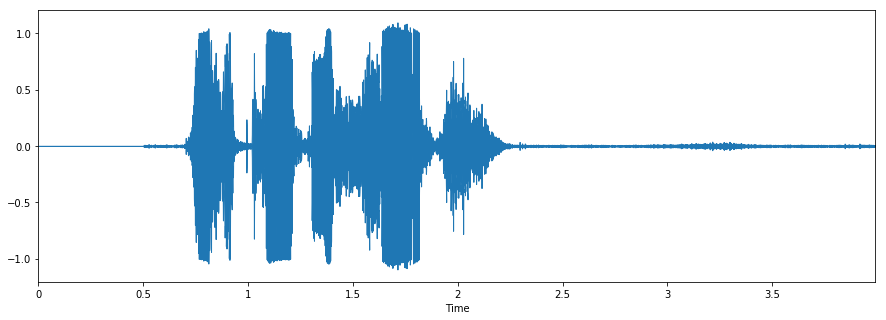

In [486]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [487]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('output10.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [488]:
livedf2= pd.DataFrame(data=livedf2)

In [489]:
livedf2 = livedf2.stack().to_frame().T

In [490]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-18.203564,-21.471836,-22.52221,-21.712259,-22.264288,-20.707904,-21.726444,-21.76865,-24.302736,-22.250634,...,-24.273819,-24.639939,-24.929152,-24.43919,-25.210171,-24.740646,-22.311913,-22.579805,-22.31466,-21.552436


In [491]:
twodim= np.expand_dims(livedf2, axis=2)

In [492]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s


In [493]:
livepreds

array([[  9.24052530e-22,   0.00000000e+00,   3.62402176e-26,
          1.30680162e-36,   4.47264152e-28,   1.00000000e+00,
          1.80208343e-30,   2.76873961e-27,   3.62227194e-23,
          1.67396652e-11]], dtype=float32)

In [494]:
livepreds1=livepreds.argmax(axis=1)

In [495]:
liveabc = livepreds1.astype(int).flatten()

In [496]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['male_angry'], dtype=object)